# Churn Prediction

The aim of this project is to find the best classification model to predict when a customer is likely to churn. In this project, 'churn' refers to the people leaving a bank, i.e., people closing their account.

For a business, this project is important because the cost to attract a new customer is much higher than the cost to retain a customer. This means that customer retention is cost-efficient, which businesses need to maximize.

The dataset for this project was taken from Kaggle.

### Dataset Exploration

In [ ]:
# Importing required modules

# Pandas and Matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Examining the dataset
df = pd.read_csv("churn_dataset.csv").drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)    # RowNumber, CustomerId, and Surname don't affect churn
df.head()

In [ ]:
# Examining data types and NaN values
df.info()

In [ ]:
# Examining labels
df['Exited'].value_counts()

# 0 -> Exited their bank (churn)
# 1 -> Didn't exit their bank (didn't churn)

In [ ]:
# Examining feature statistics
df.describe()

### Feature Selection and Data Preprocessing

In [ ]:
# Examining correlation of features with the label 'Exited'
df.corr(numeric_only=True)

Most significant features are: Age, Balance, IsActiveMember, because they have the highest correlation with the label 'Exited'. 

**Age:** Typically, older customers exhibit a higher likelihood of remaining with their bank compared to their younger customers.

**Balance:** Individuals with substantial account balances are generally less inclined to leave due to concerns about potential financial losses or the inconvenience associated with transferring funds.

**IsActiveMember:** Active customers might be constantly on the hunt for banks with the best offers, and hence are more likely to switch banks.

These 3 features will be used to create a model that predicts churn.

In [ ]:
# Visualizing distribution of Age
plt.hist(df['Age'], bins=15)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

The graph shows majority of customers in the dataset are aged between 30 and 40.

In [ ]:
# Visualizing distribution of Balance
plt.hist(df['Balance'], bins=15)
plt.title("Account Balance Distribution")
plt.xlabel("Account Balance")
plt.ylabel("Frequency")
plt.show()

The majority of accounts in the dataset have 0 balance. Other accounts seem to be normally distributed, as they form a bell curve.

In [ ]:
# Plotting features on a 3D graph
age = df['Age'].to_list()
balance = df['Balance'].to_list()
is_active_member = df['IsActiveMember'].to_list()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(age, balance, is_active_member, c='blue', marker='o', label='Data Points')

plt.title("Features")

ax.set_xlabel('Age', labelpad=15)
ax.set_ylabel('Balance', labelpad=15)
ax.set_zlabel('IsActiveMember')

plt.show()

The 3D graph does not reveal much about the distribution of data, other than two large clusters formed. Probably because there are 10000 data points plotted. 

The features need to be normalized before using them to train the model. In order to use the MinMaxScaler, Age and Balance need to be checked for potential outliers because MinMaxScaler is sensitive to outliers. IsActiveMember does not need to be checked because it is a binary column (0 or 1). 

In [ ]:
# Checking for potential outliers
def outliers(feature_list, column_name):
    '''Returns a list containing the outliers from feature_list.'''
    outliers = []

    q1 = df.describe().loc['25%', column_name]
    q3 = df.describe().loc['75%', column_name]
    iqr = q3 - q1

    for value in feature_list:
        if (value < q1 - 1.5 * iqr) or (value > q3 + 1.5 * iqr):
            outliers.append(value)

    return outliers

age_outliers = outliers(df['Age'].to_list(), 'Age')
balance_outliers = outliers(df['Balance'].to_list(), 'Balance')

print(f"Age outliers: {age_outliers}")
print(f"Balance outliers: {balance_outliers}")

Balance has no outliers. 

Customers greater than the age of 62 have been classified as outliers. However, elder people are an important aspect of the data because they might be less likely to churn, and thus cannot be removed. So, models that are robust in dealing with outliers, such as Random Forests, Support Vector Machines and K-Nearest Neighbors (immune to global outliers), will be used.

In [ ]:
# Extracting labels
labels_df = df[['Exited']]

# Normalizing features to prevent Balance dominating Age and IsActiveMember 
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(df[['Age', 'Balance', 'IsActiveMember']])

In [ ]:
# Splitting data (80/20)
X_test, X_train, Y_test, Y_train = train_test_split(normalized_features, labels_df, test_size=0.2, random_state=4353)

### Training the models

Altough Logistic Regression is not immune to outliers, it would be interesting to see how it performs against other models.

In [ ]:
# Logistic Regression
log_reg = LogisticRegression()

log_reg.fit(X_train, Y_train)

predictions = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(Y_test, predictions)

f"Accuracy: {log_reg_accuracy}"

In [ ]:
# K-Nearest Neighbors

# Selecting optimal number of neighbors (Hyperparameter tuning)
knn_accuracy = []

for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    knn_accuracy.append(accuracy_score(Y_test, predictions))

# Visualizing the accuracy
plt.scatter(list(range(1, 30)), knn_accuracy)
plt.title("RandomForest Trees Optimization")
plt.xlabel("n")
plt.ylabel("Accuracy")
plt.show()

print(f"Maximum accuracy: {max(knn_accuracy)}")

print(f"Optimal value for n (number of neighbors): {knn_accuracy.index(max(knn_accuracy)) + 1}")

In [ ]:
# Random Forest

# Selecting optimal number of Trees in Forest (Hyperparameter tuning)
rForest_accuracy = []

for n in range(1, 25):
    r_forest = RandomForestClassifier(n_estimators=n)
    r_forest.fit(X_train, Y_train)
    predictions = r_forest.predict(X_test)
    rForest_accuracy.append(accuracy_score(Y_test, predictions))

# Visualizing the accuracy
plt.scatter(list(range(1, 25)), rForest_accuracy)
plt.title("RandomForest Trees Optimization")
plt.xlabel("n")
plt.ylabel("Accuracy")
plt.show()

print(f"Maximum accuracy: {max(rForest_accuracy)}")

f"Optimal value for n (number of Trees): {rForest_accuracy.index(max(rForest_accuracy)) + 1}"

In [ ]:
# Support Vector Machine
svc = SVC()

svc.fit(X_train, Y_train)

predictions = svc.predict(X_test)

svc_accuracy = accuracy_score(Y_test, predictions)

f"SVC Accuracy: {svc_accuracy}"

Using the predictions of all 4 models (Voting Ensemble) might increase accuracy.

In [ ]:
# Voting Ensemble

# Creating individual models, using optimized hyperparameters previously calculated
ensemble_log_reg = LogisticRegression()
ensemble_rForest = RandomForestClassifier(n_estimators=rForest_accuracy.index(max(rForest_accuracy)) + 1)
ensemble_knn = KNeighborsClassifier(n_neighbors=knn_accuracy.index(max(knn_accuracy)) + 1)
ensemble_svc = SVC()

# Creating ensemble
ensemble = VotingClassifier(
    estimators=[('lr', ensemble_log_reg), ('rf', ensemble_rForest), ('knn', ensemble_knn), ('svc', ensemble_svc)], 
    voting='hard', 
    weights=[1,1,2,1])

ensemble.fit(X_train, Y_train)

predictions = ensemble.predict(X_test)

ensemble_accuracy = accuracy_score(Y_test, predictions)

f"Voting Ensemble Accuracy: {ensemble_accuracy}"

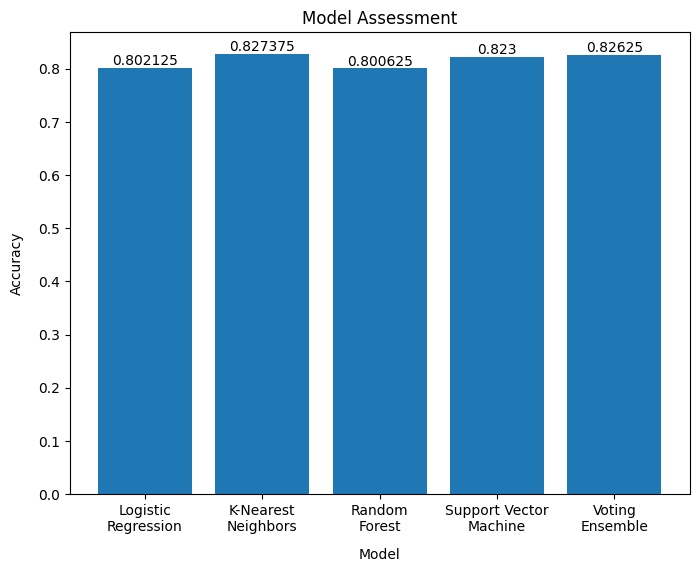

In [31]:
# Assessing the 5 models
model_names = ['Logistic\nRegression', 'K-Nearest\nNeighbors', 'Random\nForest', 'Support Vector\nMachine', 'Voting\nEnsemble']
model_accuracies = [log_reg_accuracy, max(knn_accuracy), max(rForest_accuracy), svc_accuracy, ensemble_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(model_names, model_accuracies)
plt.title('Model Assessment')
plt.xlabel('Model', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)

# Add value annotations to the bars
for idx, acc in enumerate(model_accuracies):
    plt.text(idx, acc, str(acc), ha='center', va='bottom')

plt.show()

As expected, **Logistic Regression** did not perform as good as other models, because it is sensitive to outliers. However, even **Random Forest** did not perform well, even though it is immune to outliers.

**K-Nearest Neighbors** and **Voting Ensemble** models seem to have a slight edge over the other three models when predicting churn. 

A voting ensemble could be improved by using more advanced classification algorithms as the base model, such as **Deep Neural Networks (DNNs)**, as its capable of extracting much complex patterns from the current dataset.

On the other hand, K-Nearest Neighbors is a simpler model and could be improved by supplying it with more data to train it. 

Overall, for banks, availability of data should not be a problem, so they could use any of the two models to predict churn. 

### Improvements

1.) **Imbalanced Dataset:** To enhance model accuracy, addressing the dataset's class imbalance is crucial. The limited 'not Exited' labels might have affected the model's ability to predict customer retention accurately. 

2.) **Missing Key Feature:** The dataset lacked a crucial feature — 'Interest Rate', for savings or loans. This omission is significant because interest rates can strongly influence churn. Banks offering higher savings rates or lower loan rates tend to retain customers more effectively. The absence of this feature could have limited model accuracy.

3.) **Enhanced Model Assessment:** The utilization of k-fold cross-validation offers a more comprehensive evaluation of model accuracy. This iterative training and testing approach is well-suited for robust assessments, surpassing the limitations of a single train-test split. It provides a more reliable measure of model performance 